In [1]:
!pip install tensorflow==2.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install -q tf-nightly tfp-nightly

In [3]:
import collections
import io
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import samplers

tfd = tfp.distributions
tfes = tfp.experimental.sequential

In [4]:
from google.colab import drive as mountGoogleDrive 
mountGoogleDrive.mount('/content/drive')

Mounted at /content/drive


In [5]:
in_dir = r'/content/drive/MyDrive/Research/Safegraph/scratch/20221205/'
out_dir = r'/content/drive/MyDrive/Research/Safegraph/scratch/20221205/'

In [6]:
raw_incidence = pd.read_csv(f"{in_dir}/cases.csv",
                            dtype={'UHF_id':str})
raw_mobility = pd.read_csv(f"{in_dir}/mobility/2020-08-31_mobility.csv")
raw_population = pd.read_csv(f"{in_dir}/pop.csv")

In [7]:
initial_population = raw_population['pop_est'].to_numpy().astype(np.float32)

In [8]:
raw_mobility = raw_mobility[~(raw_mobility['origin'] == raw_mobility['destination'])]

In [9]:
raw_incidence = raw_incidence.pivot(index='week_ending', columns='UHF_id', values='case_count').reset_index()

In [10]:
raw_incidence.loc[0, 'week_ending']

'2020-08-08'

In [11]:
daily_mobility_matrices = []
for i in range(1, 51):
  day_mobility = raw_mobility
  
  # Make a matrix of daily mobilities.
  z = pd.crosstab(
      day_mobility.origin, 
      day_mobility.destination, 
      values=day_mobility['visitor_home_aggregation'], aggfunc='sum', dropna=False)
  
  # Include every city, even if there are no rows for some in the raw data on
  # some day.  This uses the sort order of `raw_population`.
  z = z.reindex(index=raw_population['UHF_id'], columns=raw_population['UHF_id'], 
                fill_value=0)
  # Finally, fill any missing entries with 0. This means no mobility.
  z = z.fillna(0)
  daily_mobility_matrices.append(z.to_numpy())

mobility_matrix_over_time = np.stack(daily_mobility_matrices, axis=-1).astype(
    np.float32)

In [12]:
observed_daily_infectious_count = raw_incidence.to_numpy()[:50, 1:]
observed_daily_infectious_count = np.transpose(
    observed_daily_infectious_count).astype(np.float32)

In [13]:
print('Mobility Matrix over time should have shape (42, 42, 50): {}'.format(
    mobility_matrix_over_time.shape))
print('Observed Infectious should have shape (42, 50): {}'.format(
    observed_daily_infectious_count.shape))
print('Initial population should have shape (42): {}'.format(
    initial_population.shape))

Mobility Matrix over time should have shape (42, 42, 50): (42, 42, 50)
Observed Infectious should have shape (42, 50): (42, 50)
Initial population should have shape (42): (42,)


In [14]:
SEIRComponents = collections.namedtuple(
  typename='SEIRComponents',
  field_names=[
    'susceptible',              # S
    'exposed',                  # E
    'documented_infectious',    # I^r
    'undocumented_infectious',  # I^u
    # This is the count of new cases in the "documented infectious" compartment.
    # We need this because we will introduce a reporting delay, between a person
    # entering I^r and showing up in the observable case count data.
    # This can't be computed from the cumulative `documented_infectious` count,
    # because some portion of that population will move to the 'recovered'
    # state, which we aren't tracking explicitly.
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'documented_infectious_tx_rate',             # Beta
      'undocumented_infectious_tx_relative_rate',  # Mu
      'intercity_underreporting_factor',           # Theta
      'average_latency_period',                    # Z
      'fraction_of_documented_infections',         # Alpha
      'average_infection_duration'                 # D
    ]
)

In [15]:
PARAMETER_LOWER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=0.8,
    undocumented_infectious_tx_relative_rate=0.2,
    intercity_underreporting_factor=1.,
    average_latency_period=2.,
    fraction_of_documented_infections=0.02,
    average_infection_duration=2.
)

PARAMETER_UPPER_BOUNDS = ModelParams(
    documented_infectious_tx_rate=1.5,
    undocumented_infectious_tx_relative_rate=1.,
    intercity_underreporting_factor=1.75,
    average_latency_period=5.,
    fraction_of_documented_infections=1.,
    average_infection_duration=5.
)

In [16]:
def sample_state_deltas(
    state, population, mobility_matrix, params, seed, is_deterministic=False):
  """Computes one-step change in state, including Poisson sampling.
  
  Note that this is coded to support vectorized evaluation on arbitrary-shape
  batches of states.  This is useful, for example, for running multiple
  independent replicas of this model to compute credible intervals for the
  parameters.  We refer to the arbitrary batch shape with the conventional
  `B` in the parameter documentation below.  This function also, of course,
  supports broadcasting over the batch shape.

  Args:
    state: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the current disease state.
    population: A Tensor of shape B + [num_locations] giving the current city
      populations.
    mobility_matrix: A Tensor of shape B + [num_locations, num_locations] giving
      the current baseline inter-city mobility.
    params: A `ModelParams` tuple with fields Tensors of shape B giving the
      global parameters for the current EAKF run.
    seed: Initial entropy for pseudo-random number generation.  The Poisson
      sampling is repeatable by supplying the same seed.
    is_deterministic: A `bool` flag to turn off Poisson sampling if desired.

  Returns:
    delta: A `SEIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the one-day changes in the state, according
      to equations 1-4 above (including Poisson noise per Li et al).
  """
  undocumented_infectious_fraction = state.undocumented_infectious / population
  documented_infectious_fraction = state.documented_infectious / population

  # Anyone not documented as infectious is considered mobile
  mobile_population = (population - state.documented_infectious)
  def compute_outflow(compartment_population):
    raw_mobility = tf.linalg.matvec(
        mobility_matrix, compartment_population / mobile_population)
    return params.intercity_underreporting_factor * raw_mobility
  def compute_inflow(compartment_population):
    raw_mobility = tf.linalg.matmul(
        mobility_matrix,
        (compartment_population / mobile_population)[..., tf.newaxis],
        transpose_a=True)
    return params.intercity_underreporting_factor * tf.squeeze(
        raw_mobility, axis=-1)

  # Helper for sampling the Poisson-variate terms.
  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  # Below are the various terms called U1-U12 in the paper. We combined the
  # first two, which should be fine; both are poisson so their sum is too, and
  # there's no risk (as there could be in other terms) of going negative.
  susceptible_becoming_exposed = sample_poisson(
      state.susceptible *
      (params.documented_infectious_tx_rate *
       documented_infectious_fraction +
       (params.undocumented_infectious_tx_relative_rate *
        params.documented_infectious_tx_rate) *
       undocumented_infectious_fraction))  # U1 + U2

  susceptible_population_inflow = sample_poisson(
      compute_inflow(state.susceptible))  # U3
  susceptible_population_outflow = sample_poisson(
      compute_outflow(state.susceptible))  # U4

  exposed_becoming_documented_infectious = sample_poisson(
      params.fraction_of_documented_infections *
      state.exposed / params.average_latency_period)  # U5
  exposed_becoming_undocumented_infectious = sample_poisson(
      (1 - params.fraction_of_documented_infections) *
      state.exposed / params.average_latency_period)  # U6

  exposed_population_inflow = sample_poisson(
      compute_inflow(state.exposed))  # U7
  exposed_population_outflow = sample_poisson(
      compute_outflow(state.exposed))  # U8

  documented_infectious_becoming_recovered = sample_poisson(
      state.documented_infectious /
      params.average_infection_duration)  # U9
  undocumented_infectious_becoming_recovered = sample_poisson(
      state.undocumented_infectious /
      params.average_infection_duration)  # U10

  undocumented_infectious_population_inflow = sample_poisson(
      compute_inflow(state.undocumented_infectious))  # U11
  undocumented_infectious_population_outflow = sample_poisson(
      compute_outflow(state.undocumented_infectious))  # U12

  # The final state_deltas
  return SEIRComponents(
      # Equation [1]
      susceptible=(-susceptible_becoming_exposed +
                   susceptible_population_inflow +
                   -susceptible_population_outflow),
      # Equation [2]
      exposed=(susceptible_becoming_exposed +
               -exposed_becoming_documented_infectious +
               -exposed_becoming_undocumented_infectious +
               exposed_population_inflow +
               -exposed_population_outflow),
      # Equation [3]
      documented_infectious=(
          exposed_becoming_documented_infectious +
          -documented_infectious_becoming_recovered),
      # Equation [4]
      undocumented_infectious=(
          exposed_becoming_undocumented_infectious +
          -undocumented_infectious_becoming_recovered +
          undocumented_infectious_population_inflow +
          -undocumented_infectious_population_outflow),
      # New to-be-documented infectious cases, subject to the delayed
      # observation model.
      daily_new_documented_infectious=exposed_becoming_documented_infectious)

In [17]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  """Implement one step of RK4, wrapped around a call to sample_state_deltas."""
  # One seed for each RK sub-step
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        mobility_matrix,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

In [18]:
def initialize_state(num_particles, num_batches, seed):
  """Initialize the state for a batch of EAKF runs.
  
  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    state: A `SEIRComponents` tuple with Tensors of shape [num_particles,
      num_batches, num_cities] giving the initial conditions in each
      city, in each filter particle, in each batch member.
  """
  num_cities = mobility_matrix_over_time.shape[-2]
  state_shape = [num_particles, num_batches, num_cities]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  documented_infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  exposed = np.ones(state_shape, dtype=np.float32) * rng.randint(0, 101)
  undocumented_infectious = np.ones(state_shape, dtype=np.float32) * rng.randint(0, 101)

  # Following Li et al, we do not remove the initial exposed and infectious
  # persons from the susceptible population.
  return SEIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))
  
def initialize_params(num_particles, num_batches, seed):
  """Initialize the global parameters for the entire inference run.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the first batch of EAKF runs.
  """
  # We have 6 parameters. We'll initialize with a Sobol sequence,
  # covering the hyper-rectangle defined by our parameter limits.
  halton_sequence = tfp.mcmc.sample_halton_sequence(
      dim=6, num_results=num_particles * num_batches, seed=seed)
  halton_sequence = tf.reshape(
      halton_sequence, [num_particles, num_batches, 6])
  halton_sequences = tf.nest.pack_sequence_as(
      PARAMETER_LOWER_BOUNDS, tf.split(
          halton_sequence, num_or_size_splits=6, axis=-1))
  def interpolate(minval, maxval, h):
    return (maxval - minval) * h + minval
  return tf.nest.map_structure(
      interpolate,
      PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS, halton_sequences)

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  """Update the global parameters between EAKF runs.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    prev_params: A `ModelParams` tuple of the parameters used for the previous
      EAKF run.
    parameter_variance: A `ModelParams` tuple specifying how much to drift
      each parameter.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the next batch of EAKF runs.
  """
  # Initialize near the previous set of parameters. This is the first step
  # in Iterated Filtering.
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)

In [19]:
def raw_reporting_delay_distribution(gamma_shape=1.85, reporting_delay=9.):
  return tfp.distributions.Gamma(
      concentration=gamma_shape, rate=gamma_shape / reporting_delay)

In [20]:
def reporting_delay_probs(num_timesteps, gamma_shape=1.85, reporting_delay=9.):
  gamma_dist = raw_reporting_delay_distribution(gamma_shape, reporting_delay)
  multinomial_probs = [gamma_dist.cdf(1.)]
  for k in range(2, num_timesteps + 1):
    multinomial_probs.append(gamma_dist.cdf(k) - gamma_dist.cdf(k - 1))
  # For samples that are larger than T.
  multinomial_probs.append(gamma_dist.survival_function(num_timesteps))
  multinomial_probs = tf.stack(multinomial_probs)
  return multinomial_probs

In [21]:
def delay_reporting(
    daily_new_documented_infectious, num_timesteps, t, multinomial_probs, seed):
  # This is the distribution of observed infectious counts from the current
  # timestep.

  raw_delays = tfd.Multinomial(
      total_count=daily_new_documented_infectious,
      probs=multinomial_probs).sample(seed=seed)

  # The last bucket is used for samples that are out of range of T + 1. Thus
  # they are not going to be observable in this model.
  clipped_delays = raw_delays[..., :-1]

  # We can also remove counts that are such that t + i >= T.
  clipped_delays = clipped_delays[..., :num_timesteps - t]
  # We finally shift everything by t. That means prepending with zeros.
  return tf.concat([
      tf.zeros(
          tf.concat([
              tf.shape(clipped_delays)[:-1], [t]], axis=0),
          dtype=clipped_delays.dtype),
      clipped_delays], axis=-1)

In [22]:
ParameterStatePair = collections.namedtuple(
    'ParameterStatePair', ['state', 'params'])

# Info that is tracked and mutated but should not have inference performed over.
SideInfo = collections.namedtuple(
    'SideInfo', [
        # Observations at every time step.
        'observations_over_time',
        'initial_population',
        'mobility_matrix_over_time',
        'population',
        # Used for variance of measured observations.
        'actual_reported_cases',
        # Pre-computed buckets for the multinomial distribution.
        'multinomial_probs',
        'seed',
    ])

# Cities can not fall below this fraction of people
MINIMUM_CITY_FRACTION = 0.6

# How much to inflate the covariance by.
INFLATION_FACTOR = 1.1

INFLATE_FN = tfes.inflate_by_scaled_identity_fn(INFLATION_FACTOR)

In [23]:
# We observe the observed infections.
def observation_fn(t, state_params, extra):
  """Generate reported cases.
  
  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    observations: A Tensor of predicted observables, namely new cases
      per city at time `t`.
    extra: Update `SideInfo`.
  """
  # Undo padding introduced in `inference`.
  daily_new_documented_infectious = state_params.state.daily_new_documented_infectious[..., 0]
  # Number of people that we have already committed to become
  # observed infectious over time.
  # shape: batch + [num_particles, num_cities, time]
  observations_over_time = extra.observations_over_time
  num_timesteps = observations_over_time.shape[-1]

  seed, new_seed = samplers.split_seed(extra.seed, salt='reporting delay')
  
  daily_delayed_counts = delay_reporting(
      daily_new_documented_infectious, num_timesteps, t,
      extra.multinomial_probs, seed)
  observations_over_time = observations_over_time + daily_delayed_counts

  extra = extra._replace(
      observations_over_time=observations_over_time,
      seed=new_seed)

  # Actual predicted new cases, re-padded.
  adjusted_observations = observations_over_time[..., t][..., tf.newaxis]
  # Finally observations have variance that is a function of the true observations:
  return tfd.MultivariateNormalDiag(
      loc=adjusted_observations,
      scale_diag=tf.math.maximum(
          2., extra.actual_reported_cases[..., t][..., tf.newaxis] / 2.)), extra

In [24]:
def transition_fn(t, state_params, extra):
  """SEIR dynamics.

  Args:
    state_params: A `ParameterStatePair` giving the current parameters
      and state.
    t: Integer giving the current time.
    extra: A `SideInfo` carrying auxiliary information.

  Returns:
    state_params: A `ParameterStatePair` predicted for the next time step.
    extra: Updated `SideInfo`.
  """
  mobility_t = extra.mobility_matrix_over_time[..., t]
  new_seed, rk4_seed = samplers.split_seed(extra.seed, salt='Transition')
  new_state = rk4_one_step(
      state_params.state,
      extra.population,
      mobility_t,
      state_params.params,
      seed=rk4_seed)

  # Make sure population doesn't go below MINIMUM_CITY_FRACTION.
  new_population = (
      extra.population + state_params.params.intercity_underreporting_factor * (
          # Inflow
          tf.reduce_sum(mobility_t, axis=-2) - 
          # Outflow
          tf.reduce_sum(mobility_t, axis=-1)))
  new_population = tf.where(
      new_population < MINIMUM_CITY_FRACTION * extra.initial_population,
      extra.initial_population * MINIMUM_CITY_FRACTION,
      new_population)

  extra = extra._replace(population=new_population, seed=new_seed)

  # The Ensemble Kalman Filter code expects the transition function to return a distribution.
  # As the dynamics and noise are encapsulated above, we construct a `JointDistribution` that when
  # sampled, returns the values above.

  new_state = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), new_state))
  params = tfd.JointDistributionNamed(
      model=tf.nest.map_structure(lambda x: tfd.VectorDeterministic(x), state_params.params))
  
  state_params = tfd.JointDistributionNamed(
      model=ParameterStatePair(state=new_state, params=params))

  return state_params, extra

In [54]:
# Use tf.function to speed up EAKF prediction and updates.
ensemble_kalman_filter_predict = tf.function(
    tfes.ensemble_kalman_filter_predict, autograph=False)
ensemble_adjustment_kalman_filter_update = tf.function(
    tfes.ensemble_adjustment_kalman_filter_update, autograph=False)

def inference(
    num_ensembles,
    num_batches,
    num_iterations,
    actual_reported_cases,
    mobility_matrix_over_time,
    seed=None,
    # This is how much to reduce the variance by in every iterative
    # filtering step.
    variance_shrinkage_factor=0.9,
    # Days before infection is reported.
    reporting_delay=9.,
    # Shape parameter of Gamma distribution.
    gamma_shape_parameter=1.85):
  """Inference for the Shaman, et al. model.

  Args:
    num_ensembles: Number of particles to use for EAKF.
    num_batches: Number of batches of IF-EAKF to run.
    num_iterations: Number of iterations to run iterative filtering.
    actual_reported_cases: `Tensor` of shape `[L, T]` where `L` is the number
      of cities, and `T` is the timesteps.
    mobility_matrix_over_time: `Tensor` of shape `[L, L, T]` which specifies the
      mobility between locations over time.
    variance_shrinkage_factor: Python `float`. How much to reduce the
      variance each iteration of iterated filtering.
    reporting_delay: Python `float`. How many days before the infection
      is reported.
    gamma_shape_parameter: Python `float`. Shape parameter of Gamma distribution
      of reporting delays.

  Returns:
    result: A `ModelParams` with fields Tensors of shape [num_batches],
      containing the inferred parameters at the final iteration.
  """
  print('Starting inference.')
  num_timesteps = actual_reported_cases.shape[-1]
  params_per_iter = []

  multinomial_probs = reporting_delay_probs(
      num_timesteps, gamma_shape_parameter, reporting_delay)

  seed = samplers.sanitize_seed(seed, salt='Inference')

  for i in range(num_iterations):
    start_if_time = time.time()
    seeds = samplers.split_seed(seed, n=4, salt='Initialize')
    if params_per_iter:
      parameter_variance = tf.nest.map_structure(
          lambda minval, maxval: 0.0001,
          PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)
      # parameter_variance = tf.nest.map_structure(
      #     lambda minval, maxval: variance_shrinkage_factor ** (
      #         2 * i) * (maxval - minval) ** 2 / 4.,
      #     PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)
      params_t = update_params(
          num_ensembles,
          num_batches,
          prev_params=params_per_iter[-1],
          parameter_variance=parameter_variance,
          seed=seeds.pop())
    else:
      params_t = initialize_params(num_ensembles, num_batches, seed=seeds.pop())

    state_t = initialize_state(num_ensembles, num_batches, seed=seeds.pop())
    population_t = sum(x for x in state_t)
    observations_over_time = tf.zeros(
        [num_ensembles,
         num_batches,
         actual_reported_cases.shape[0], num_timesteps])

    extra = SideInfo(
        observations_over_time=observations_over_time,
        initial_population=tf.identity(population_t),
        mobility_matrix_over_time=mobility_matrix_over_time,
        population=population_t,
        multinomial_probs=multinomial_probs,
        actual_reported_cases=actual_reported_cases,
        seed=seeds.pop())

    # Clip states
    state_t = clip_state(state_t, population_t)
    params_t = clip_params(params_t, seed=seeds.pop())

    # Accrue the parameter over time. We'll be averaging that
    # and using that as our MLE estimate.
    params_over_time = tf.nest.map_structure(
        lambda x: tf.identity(x), params_t)
    state_over_time = tf.nest.map_structure(
        lambda x: tf.identity(x), state_t)


    state_params = ParameterStatePair(state=state_t, params=params_t)

    eakf_state = tfes.EnsembleKalmanFilterState(
        step=tf.constant(0), particles=state_params, extra=extra)

    for j in range(num_timesteps):
      seeds = samplers.split_seed(eakf_state.extra.seed, n=3)
      
      extra = extra._replace(seed=seeds.pop())
    
      # Predict step.

      # Inflate and clip.
      new_particles = INFLATE_FN(eakf_state.particles)
      state_t = clip_state(new_particles.state, eakf_state.extra.population)
      params_t = clip_params(new_particles.params, seed=seeds.pop())
      eakf_state = eakf_state._replace(
          particles=ParameterStatePair(params=params_t, state=state_t))

      eakf_predict_state = ensemble_kalman_filter_predict(eakf_state, transition_fn)

      # Clip the state and particles.
      state_params = eakf_predict_state.particles
      state_t = clip_state(
          state_params.state, eakf_predict_state.extra.population)
      state_params = ParameterStatePair(state=state_t, params=state_params.params)

      # We preprocess the state and parameters by affixing a 1 dimension. This is because for
      # inference, we treat each city as independent. We could also introduce localization by
      # considering cities that are adjacent.
      state_params = tf.nest.map_structure(lambda x: x[..., tf.newaxis], state_params)
      eakf_predict_state = eakf_predict_state._replace(particles=state_params)

      # Update step.
      
      eakf_update_state = ensemble_adjustment_kalman_filter_update(
          eakf_predict_state,
          actual_reported_cases[..., j][..., tf.newaxis],
          observation_fn)
      
      state_params = tf.nest.map_structure(
          lambda x: x[..., 0], eakf_update_state.particles)

      # Clip to ensure parameters / state are well constrained.
      state_t = clip_state(
          state_params.state, eakf_update_state.extra.population)
      
      # Finally for the parameters, we should reduce over all updates. We get
      # an extra dimension back so let's do that.
      params_t = tf.nest.map_structure(
          lambda x, y: x + tf.reduce_sum(y[..., tf.newaxis] - x, axis=-2, keepdims=True),
          eakf_predict_state.particles.params, state_params.params)
      params_t = clip_params(params_t, seed=seeds.pop())
      params_t = tf.nest.map_structure(lambda x: x[..., 0], params_t)

      state_params = ParameterStatePair(state=state_t, params=params_t)
      eakf_state = eakf_update_state
      eakf_state = eakf_state._replace(particles=state_params)

      # Flatten and collect the inferred parameter at time step t.
      params_over_time = tf.nest.map_structure(
          lambda s, x: tf.concat([s, x], axis=-1), params_over_time, params_t)
      state_over_time = tf.nest.map_structure(
          lambda s, x: tf.concat([s, x], axis=-1), state_over_time, state_t)
      
    est_params = tf.nest.map_structure(
        # Take the average over the Ensemble and over time.
        lambda x: tf.math.reduce_mean(x, axis=[0, -1])[..., tf.newaxis],
        params_over_time)
    params_per_iter.append(est_params)
    print('Iterated Filtering {} / {} Ran in: {:.2f} seconds'.format(
        i, num_iterations, time.time() - start_if_time))

  return tf.nest.map_structure(lambda x: tf.squeeze(x, axis=-1), params_per_iter[-1]), params_over_time, state_over_time

In [55]:
def clip_state(state, population):
  """Clip state to sensible values."""
  state = tf.nest.map_structure(
      lambda x: tf.where(x < 0, 0., x), state)

  # If S > population, then adjust as well.
  susceptible = tf.where(state.susceptible > population, population, state.susceptible)
  return SEIRComponents(
      susceptible=susceptible,
      exposed=state.exposed,
      documented_infectious=state.documented_infectious,
      undocumented_infectious=state.undocumented_infectious,
      daily_new_documented_infectious=state.daily_new_documented_infectious)

def clip_params(params, seed):
  """Clip parameters to bounds."""
  def _clip(p, minval, maxval):
    return tf.where(
        p < minval,
        minval * (1. + 0.1 * tf.random.stateless_uniform(p.shape, seed=seed)),
        tf.where(p > maxval,
                 maxval * (1. - 0.1 * tf.random.stateless_uniform(
                     p.shape, seed=seed)), p))
  params = tf.nest.map_structure(
      _clip, params, PARAMETER_LOWER_BOUNDS, PARAMETER_UPPER_BOUNDS)

  return params

In [56]:
best_parameters, params_over_time, state_over_time = inference(
    num_ensembles=300,
    num_batches=30,
    num_iterations=15,
    actual_reported_cases=observed_daily_infectious_count,
    mobility_matrix_over_time=mobility_matrix_over_time)

Starting inference.
Iterated Filtering 0 / 15 Ran in: 119.63 seconds
Iterated Filtering 1 / 15 Ran in: 114.30 seconds
Iterated Filtering 2 / 15 Ran in: 115.02 seconds
Iterated Filtering 3 / 15 Ran in: 116.08 seconds
Iterated Filtering 4 / 15 Ran in: 114.79 seconds
Iterated Filtering 5 / 15 Ran in: 112.89 seconds
Iterated Filtering 6 / 15 Ran in: 115.04 seconds
Iterated Filtering 7 / 15 Ran in: 114.86 seconds
Iterated Filtering 8 / 15 Ran in: 114.35 seconds
Iterated Filtering 9 / 15 Ran in: 113.64 seconds
Iterated Filtering 10 / 15 Ran in: 114.15 seconds
Iterated Filtering 11 / 15 Ran in: 114.49 seconds
Iterated Filtering 12 / 15 Ran in: 115.05 seconds
Iterated Filtering 13 / 15 Ran in: 113.92 seconds
Iterated Filtering 14 / 15 Ran in: 115.26 seconds


In [29]:
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages(f"{out_dir}/case_counts_3.pdf")
for l in range(42):
  fig = plt.figure(figsize=(18,12))
  plt.plot(tf.transpose(tf.squeeze(state_over_time.daily_new_documented_infectious[:,0]))[l::42], color='gray')
  plt.plot(raw_incidence.iloc[0:50,1+l], 'x', color='red')
  pdf.savefig(fig)
pdf.close()


<ipython-input-29-73dcdbc6a4de>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,12))
<ipython-input-29-73dcdbc6a4de>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(18,12))
<ipython-input-29-73dcdbc6a4de>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figu

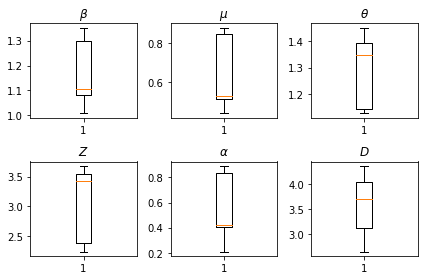

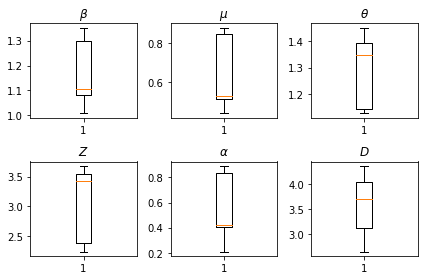

In [52]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].boxplot(best_parameters.documented_infectious_tx_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 0].set_title(r'$\beta$')

axs[0, 1].boxplot(best_parameters.undocumented_infectious_tx_relative_rate,
                  whis=(2.5,97.5), sym='')
axs[0, 1].set_title(r'$\mu$')

axs[0, 2].boxplot(best_parameters.intercity_underreporting_factor,
                  whis=(2.5,97.5), sym='')
axs[0, 2].set_title(r'$\theta$')

axs[1, 0].boxplot(best_parameters.average_latency_period,
                  whis=(2.5,97.5), sym='')
axs[1, 0].set_title(r'$Z$')

axs[1, 1].boxplot(best_parameters.fraction_of_documented_infections,
                  whis=(2.5,97.5), sym='')
axs[1, 1].set_title(r'$\alpha$')

axs[1, 2].boxplot(best_parameters.average_infection_duration,
                  whis=(2.5,97.5), sym='')
axs[1, 2].set_title(r'$D$')
plt.tight_layout()

In [51]:
plt.ion()